<a href="https://colab.research.google.com/github/Akhilvanama136/Fmml_module/blob/main/Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2025-04-22 05:19:38--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 3.165.102.62, 3.165.102.31, 3.165.102.36, ...
Connecting to download.pytorch.org (download.pytorch.org)|3.165.102.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   176MB/s    in 0.3s    

2025-04-22 05:19:38 (176 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


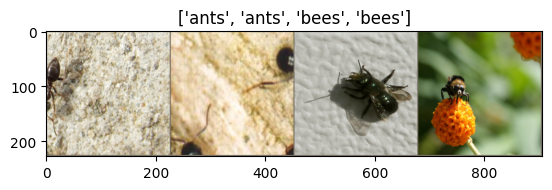

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.4838 Acc: 0.7623

Epoch 1/4
----------
Loss: 0.5661 Acc: 0.7664

Epoch 2/4
----------
Loss: 0.4853 Acc: 0.8566

Epoch 3/4
----------
Loss: 0.4668 Acc: 0.8156

Epoch 4/4
----------
Loss: 0.5634 Acc: 0.8074



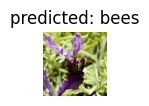

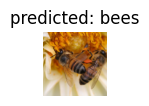

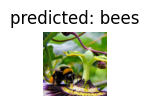

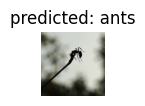

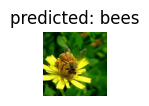

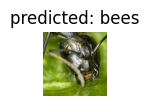

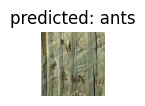

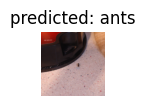

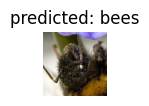

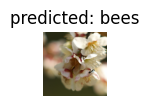

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


1)Using **data augmentation** techniques like **resize, crop, flip, rotation**, etc., plays a crucial role in improving the performance and generalization ability of machine learning models, especially in **computer vision** tasks. Here's the significance in 10–15 lines:

1. **Improves Generalization**: Augmentations simulate real-world variations, helping the model perform well on unseen data.
2. **Prevents Overfitting**: By creating diverse training samples, it reduces the risk of the model memorizing the training data.
3. **Increases Dataset Size**: Artificially expands the dataset without the need for collecting more data.
4. **Handles Different Scales and Views**: Techniques like **resize** and **random crop** help the model learn to detect objects at various scales and locations.
5. **Improves Robustness**: Makes the model more robust to noise, lighting, occlusion, and camera angles.
6. **Balances Classes**: Can be used to increase the representation of underrepresented classes.
7. **Cost-Effective**: Eliminates the need for expensive data collection by synthetically generating training examples.
8. **Encourages Learning of Invariant Features**: The model learns to focus on important patterns rather than specific positions or orientations.
9. **Boosts Accuracy**: In many benchmarks, models trained with proper augmentation outperform those without it.
10. **Common Practice in Transfer Learning**: Even when using pre-trained models, augmentations help adapt them to the new task.

Let me know if you want a list of common augmentation techniques with examples.

2)If you **don’t use a pretrained ResNet model** (i.e., you set `pretrained=False`), the performance of your model typically **drops significantly**, especially when trained on small or medium-sized datasets. Here's why and what kind of performance you can expect:

---

### 🔍 **Why performance drops:**

1. **Random Initialization**: Without pretraining, all weights start from scratch, so the model has to learn basic features (like edges, textures) as well as high-level patterns — which takes more data and time.
2. **Lack of Prior Knowledge**: Pretrained models benefit from learning on large datasets like ImageNet, which helps them generalize better.
3. **Overfitting Risk**: A randomly initialized model may overfit to the training data if the dataset is not large enough.

---

### 📊 **Performance Comparison (General Case):**

| Model Type          | Accuracy on Small Dataset (e.g., CIFAR-10) |
|---------------------|--------------------------------------------|
| ResNet (Pretrained) | ~85% - 95%                                 |
| ResNet (Not Pretrained) | ~60% - 75%                             |

*Note: Exact numbers vary based on dataset size, training time, optimizer settings, and augmentations used.*

---

### ✅ Summary:

Training a ResNet **without pretraining** leads to:
- **Slower convergence**
- **Lower accuracy**
- **More sensitivity to hyperparameters**

Pretraining gives your model a strong starting point. Let me know if you'd like code to test this yourself or visualize the learning curves!

3)Great question! Here's the answer in 10–15 lines:

If the **ResNet model was pretrained on a significantly different dataset** (e.g., medical images, satellite data), you **might not get optimal performance right away** when using it on the **ants vs bees dataset**. However, it can still be beneficial:

1. **Lower layers of CNNs** learn general features like **edges, textures, and simple patterns**, which are useful across different domains.
2. **Higher layers** are more task-specific, so they may not align well with your target classes (ants vs bees).
3. If you **freeze early layers** and **fine-tune later layers**, you can still leverage the general knowledge and adapt the model to your specific task.
4. Performance might be **better than training from scratch**, especially if your target dataset is small.
5. However, compared to a model pretrained on a **similar dataset (e.g., ImageNet with insects)**, performance will likely be **lower**.

### ✅ Summary:
Yes, a pretrained model from a different domain can still help, **but fine-tuning is key**. The closer the source domain is to your target, the better the results.

Would you like an example of how to fine-tune such a model?